Microglial INPP5D limits plaque formation and glial reactivity in the PSAPP mouse model of Alzheimer’s disease

* Paper: DOI: 10.1002/alz.12821
* Aim of the analysis:
    * Annotate the data
    * Pathway analysis



In [1]:
suppressMessages(library("SpatialExperiment"))
suppressMessages(library("SingleCellExperiment"))
suppressMessages(library("DropletUtils"))
suppressMessages(library("Seurat"))
suppressMessages(library("ggspavis"))
suppressMessages(library("scater"))
suppressMessages(library("ggplot2"))
suppressMessages(library("patchwork"))
suppressMessages(library("biomaRt"))
suppressMessages(library("nnSVG"))
suppressMessages(library("scran"))
suppressMessages(library("igraph"))
suppressMessages(library("glue"))
# suppressMessages(library("BayesSpace"))
# suppressMessages(library("pheatmap"))

Warning message:
“package ‘DropletUtils’ was built under R version 4.4.3”
Warning message:
“package ‘SeuratObject’ was built under R version 4.4.3”


In [ ]:
# # another options for vscode for plotting
# options(repr.plot.width = 10, repr.plot.height = 5, jupyter.plot_scale = 1)
# # make the resolution better
options(repr.plot.res = 300) # set dpy to 200

In [ ]:
# options(repr.plot.width = , repr.plot.height = "auto", jupyter.plot_scale = 1, repr.plot.res = "auto")

In [ ]:
main_folder <- "/home/kharuk/projects/courses/st_daad/data"  # Change to your actual path

# List all sample directories inside the main folder
sample_dirs <- list.dirs(main_folder, recursive = FALSE)

print(sample_dirs)  # Check detected directories

In [ ]:
sample_id <- "GSM6171784_PSAPP_CO1"

In [ ]:
# upload one sample for preprocessing
spe <- read10xVisium(
        samples = sample_dirs[1],
        sample_id = "GSM6171784_PSAPP_CO1",
        data = "filtered",
        type = "sparse",
        images = "lowres",
        load = TRUE
)

In [ ]:
# move rownames to rowData names new column ensembl_id
rowData(spe)$ensembl_id <- rownames(rowData(spe))

### Sample preprocessing

#### Plot data

In [ ]:
# plot spatial coordinates (spots)
plotSpots(spe)

#### QC metrics

In [ ]:
# First, we subset the object to keep only spots over tissue.
# subset the object to keep only spots over tissue
spe <- spe[, colData(spe)$in_tissue == 1]
dim(spe)

In [ ]:
colData(spe)

In [ ]:
# identify mito genes
is_mito <- grepl("(^MT-|^mt-)", rowData(spe)$symbol)
table(is_mito)

In [ ]:
# print mito genes
rowData(spe)$symbol[is_mito]

In [ ]:
# calculate per-spot QC metrics and store in coldata 
spe <- addPerCellQC(spe, subsets = list(mito = is_mito))
head(colData(spe))

#### Selecting thresholds for filtering

Have to select thresholds for several QC metrics: (i) library size, (ii) number of expressed genes, (iii) proportion of mitochondrial reads, and (iv) number of cells per spot (does not exist in data).

Library size represents the total sum of UMI counts per spot.

In [ ]:
hist(colData(spe)$sum, breaks = 20)

In [ ]:
colData(spe)

In [ ]:
# histograms of QC metrics before filtering
par(mfrow = c(3, 3))
hist(colData(spe)$sum, xlab = "sum", main = "UMIs per spot")
hist(colData(spe)$detected, xlab = "detected", main = "Genes per spot")
hist(colData(spe)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")
# hist(colData(spe)$cell_count, xlab = "number of cells", main = "No. cells per spot")

In [ ]:
# asign gene names for plotting 
rownames(spe) <- rowData(spe)$symbol
colData(spe)$sum <- colSums(counts(spe))

In [ ]:
# plot the same QC on the spatial coordinates
pal <- c("#fde725", "navy")
p1 <- plotSpots(spe, annotate = "sum", pal = "viridis", point_size = 0.03) +  
    theme_void()
p2 <- plotSpots(spe, annotate = "detected", pal = "viridis", point_size = 0.03) + 
    theme_void()
p3 <- plotSpots(spe, annotate = "subsets_mito_percent", pal = "viridis", point_size = 0.03) + 
    theme_void()a


qc_before <- wrap_plots(p1, p2, p3, nrow = 1) + 
    plot_annotation(title = glue("QC metrics for {sample_id} before filtering"))
qc_before
ggsave(filename = glue("qc_metrics_{sample_id}_before_filtering.png"), plot = qc_before, width = 10, dpi = 300)

In [ ]:
# plot QC with image included
p1 <- plotVisium(spe, annotate = "sum", highlight = "in_tissue", point_size = 0.75) + 
    theme_void()

p2 <- plotVisium(spe, annotate = "detected", highlight = "in_tissue", point_size = 0.75) +
    theme_void()
p3 <- plotVisium(spe, annotate = "subsets_mito_percent", highlight = "in_tissue", point_size = 0.75) + 
    theme_void()
tissue_plot <- plotVisium(spe, highlight = "in_tissue", spots = FALSE) + 
    theme_void()


# display panels using patchwork
final_plot <- wrap_plots(p1, p2, p3, tissue_plot, nrow = 1) +
  plot_annotation(title = glue("QC metrics for {sample_id} before filtering"))

ggsave(glue("qc_metrics_{sample_id}_tissue.png"), final_plot, width = 20, height = 5, dpi = 200)


Another option is to calculate MAD and filter based on this value.

In [ ]:
# determine outliers via thresholding on MAD from the median
ol <- perCellQCFilters(spe, sub.fields="subsets_mito_percent")
# add results as cell metadata
colData(spe)[names(ol)] <- ol 
# tabulate # and % of cells that'd 
# be discarded for different reasons
data.frame(
    check.names=FALSE,
    `#`=apply(ol, 2, sum), 
    `%`=round(100*apply(ol, 2, mean), 2))


In [ ]:
# plot what spots will be discarded with MAD
lapply(names(ol), \(.) 
    plotSpots(spe, annotate=.) + ggtitle(.)) |>
    wrap_plots(nrow=1, guides="collect") +
    plot_annotation(title = glue("Spots flagged for discard {sample_id}")) &
    guides(col=guide_legend(override.aes=list(size=3))) &
    scale_color_manual("discard", values=c("lavender", "purple")) &
    theme(plot.title=element_text(hjust=0.5, size=8), 
        legend.key.size=unit(0.8, "lines")
    )

I'd like not to remove the outliers with MAD, but to set a threshold for each of the QC metrics: library size (sum), number of expressed genes (detected), proportion of mitochondrial reads (subset_mito_percent)

In [ ]:
# Set the threshold manually 
# select QC thresholds
qc_lib_size <- colData(spe)$sum < 600
qc_detected <- colData(spe)$detected < 400
# qc_mito <- colData(spe)$subsets_mito_percent > 30

# number of discarded spots for each metric
apply(cbind(qc_lib_size, qc_detected), 2, sum)

In [ ]:
# combined set of discarded spots
discard <- qc_lib_size | qc_detected
table(discard)

In [ ]:
# store in object
colData(spe)$discard <- discard

Plot the set of discarded spots in the spatial x-y coordinates, to confirm that the spatial distribution of the discarded spots does not correspond to any biologically meaningful regions, which would indicate that we are removing biologically informative spots.

In [ ]:
plotSpotQC(spe, plot_type = "spot", annotate = "discard") + 
    plot_annotation(title = "Spots to be discarded")

In [ ]:
# filter low-quality spots
spe <- spe[, !colData(spe)$discard]
dim(spe)


In [ ]:
# plot the same QC on the spatial coordinates
p1 <- plotSpots(spe, annotate = "sum", pal = "viridis", point_size = 0.03) +  
    theme_void()
p2 <- plotSpots(spe, annotate = "detected", pal = "viridis", point_size = 0.03) + 
    theme_void()
p3 <- plotSpots(spe, annotate = "subsets_mito_percent", pal = "viridis", point_size = 0.03) + 
    theme_void()


qc_after <- wrap_plots(p1, p2, p3, nrow = 1) + 
    plot_annotation(title = glue("QC metrics for {sample_id} before filtering"))
qc_after
ggsave(filename = glue("qc_metrics_{sample_id}_after_filtering.png"), plot = qc_after, width = 10, dpi = 300)

In [ ]:
# p1 <- plotVisium(spe, annotate = "sum", highlight = "in_tissue", image = FALSE, point_size = 1)
# p2 <- plotVisium(spe, annotate = "subsets_mito_percent", highlight = "in_tissue", image = FALSE, point_size = 1)
# p3 <- plotVisium(spe, annotate = "Cst7", highlight = "in_tissue", image = FALSE, point_size = 1)

# wrap_plots(p1, p2, p3, ncol = 2) + 
#     plot_annotation(title = "QC metrics after filtering")

#### Normalization, Feature selection, DR, Clustering and Visualization

##### Non-spatial Normalization

In [ ]:
# calculate library size factors
spe <- computeLibraryFactors(spe)
summary(sizeFactors(spe))

In [ ]:
hist(sizeFactors(spe), breaks = 20)

In [ ]:
# calculate logcounts and store in object
spe <- logNormCounts(spe)

assayNames(spe)

#### Feature selection 

##### Non-spatial Feature selection

In [ ]:
# remove mitochondrial genes
spe <- spe[!is_mito, ]
dim(spe)


In [ ]:
# fit mean-variance relationship
dec <- modelGeneVar(spe)

# visualize mean-variance relationship
fit <- metadata(dec)
plot(fit$mean, fit$var, 
     xlab = "mean of log-expression", ylab = "variance of log-expression")
curve(fit$trend(x), col = "dodgerblue", add = TRUE, lwd = 2)

In [ ]:
# select top HVGs
top_hvgs <- getTopHVGs(dec, prop = 0.1)
length(top_hvgs)

#### Dimensionality reduction

In [ ]:
# run PCA and UMAP
spe <- runPCA(spe, subset_row=top_hvgs)
spe <- runUMAP(spe, dimred="PCA", pca = 30) # use 30 PCs as in the paper

##### Clustering

In [ ]:
# build shared nearest-neighbor (SNN) graph
g <- buildSNNGraph(spe, use.dimred="PCA", type="jaccard")
# cluster via Leiden community detection algorithm
k <- cluster_leiden(g, objective_function="modularity", resolution=0.8)
table(spe$Leiden <- factor(k$membership))

In [ ]:
spe


In [ ]:
# plot clusters in spatial x-y coordinates
spatial_p1 <- plotSpots(spe, annotate = "Leiden", legend_position = "none") +
  scale_color_manual(values = unname(pals::trubetskoy()))  # Custom color palette for spatial plot

umap_p2 <- plotDimRed(spe, plot_type = "UMAP", 
           annotate = "Leiden") +
  scale_color_manual(values = unname(pals::trubetskoy()))  # Custom color palette for spatial plot


wrap_plots(spatial_p1, umap_p2, nrow=1) +
    plot_annotation(title = glue("Leiden clusters for {sample_id}"))


    

In [ ]:
# save the object
saveRDS(spe, file = glue("../data/ST_{sample_id}.rds"))

##### Spatially-aware: Spatially variable genes (SVGs). *Eternally running :)*

In [ ]:
# # filter low-expressed and mitochondrial genes
# # using very stringent filtering parameters for faster runtime in this example
# # note: for a full analysis, use alternative filtering parameters (e.g. defaults)

# # re-calculate logcounts after filtering
# # using library size factors
spe_nnSVG <- logNormCounts(spe)
# 
# # run nnSVG
# # using a single core for compatibility on build system
# # note: for a full analysis, use multiple cores
set.seed(123)
spe_nnSVG <- nnSVG(spe_nnSVG, n_threads = 6)
# 
# # investigate results
# 
# # show results
head(rowData(spe_nnSVG), 3)
# 
# # number of significant SVGs
table(rowData(spe_nnSVG)$padj <= 0.05)
# 
# # show results for top n SVGs
rowData(spe_nnSVG)[order(rowData(spe_nnSVG)$rank)[1:6], ]
# 
# # identify top-ranked SVG
rowData(spe_nnSVG)$symbol[which(rowData(spe_nnSVG)$rank == 1)]




## Preprocess all samples

In [2]:
# upload samples

main_folder <- "/home/kharuk/projects/courses/st_daad/data"  # Change to your actual path

# List all sample directories inside the main folder
sample_dirs <- list.dirs(main_folder, recursive = FALSE)

print(sample_dirs)  # Check detected directories

[1] "/home/kharuk/projects/courses/st_daad/data/GSM6171784_PSAPP_CO1" 
[2] "/home/kharuk/projects/courses/st_daad/data/GSM6171785_PSAPP_TAM1"
[3] "/home/kharuk/projects/courses/st_daad/data/GSM6171788_PSAPP_CO2" 
[4] "/home/kharuk/projects/courses/st_daad/data/GSM6171789_PSAPP_TAM2"
[5] "/home/kharuk/projects/courses/st_daad/data/GSM6171792_PSAPP_CO3" 
[6] "/home/kharuk/projects/courses/st_daad/data/GSM6171793_PSAPP_TAM3"


In [9]:
# function to preprocess a single sample
preprocess_sample <- function(sample_path) {

    sample_id <- basename(sample_path)

    spe <- read10xVisium(
        samples = sample_path,
        sample_id = sample_id,
        data = "filtered",
        type = "sparse",
        images = "lowres",
        load = TRUE
    )

    # First, we subset the object to keep only spots over tissue.
    # subset the object to keep only spots over tissue
    spe <- spe[, colData(spe)$in_tissue == 1]
    dim(spe)

    # identify mito genes
    is_mito <- grepl("(^MT-|^mt-)", rowData(spe)$symbol)
    table(is_mito)

    # calculate per-spot QC metrics and store in coldata 
    spe <- addPerCellQC(spe, subsets = list(mito = is_mito))
    head(colData(spe))


    # histograms of QC metrics before filtering # TODO add title here 
    png(glue("qc_hist_{sample_id}.png"), width = 1000, height = 800)
    par(mfrow = c(3, 3), oma = c(0, 0, 3, 0))  # layout

    hist(colData(spe)$sum, xlab = "sum", main = "UMIs per spot")
    hist(colData(spe)$detected, xlab = "detected", main = "Genes per spot")
    hist(colData(spe)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")

    mtext(glue("QC histograms for {sample_id}"), outer = TRUE, cex = 1)

    dev.off()
    # asign gene names for plotting 
    rownames(spe) <- rowData(spe)$symbol
    colData(spe)$sum <- colSums(counts(spe))

    # plot the same QC on the spatial coordinates
    pal <- c("#fde725", "navy")
    p1 <- plotSpots(spe, annotate = "sum", pal = "viridis", point_size = 0.03) +  
        theme_void()
    p2 <- plotSpots(spe, annotate = "detected", pal = "viridis", point_size = 0.03) + 
        theme_void()
    p3 <- plotSpots(spe, annotate = "subsets_mito_percent", pal = "viridis", point_size = 0.03) + 
        theme_void()
    qc_before <- wrap_plots(p1, p2, p3, nrow = 1) + 
        plot_annotation(title = glue("QC metrics for {sample_id} before filtering"))
    print(qc_before)
    ggsave(filename = glue("qc_metrics_{sample_id}_before_filtering.png"), plot = qc_before, width = 10, dpi = 300)

    # plot QC with image included
    p1 <- plotVisium(spe, annotate = "sum", highlight = "in_tissue", point_size = 0.75) + 
        theme_void()

    p2 <- plotVisium(spe, annotate = "detected", highlight = "in_tissue", point_size = 0.75) +
        theme_void()
    p3 <- plotVisium(spe, annotate = "subsets_mito_percent", highlight = "in_tissue", point_size = 0.75) + 
        theme_void()
    tissue_plot <- plotVisium(spe, highlight = "in_tissue", spots = FALSE) + 
        theme_void()

    # display panels using patchwork
    qc_tissue_plot <- wrap_plots(p1, p2, p3, tissue_plot, nrow = 1) +
    plot_annotation(title = glue("QC metrics for {sample_id} before filtering"))
    print(qc_tissue_plot)
    ggsave(glue("qc_metrics_{sample_id}_tissue.png"), qc_tissue_plot, width = 20, height = 5, dpi = 200)


    # determine outliers via thresholding on MAD from the median
    ol <- perCellQCFilters(spe, sub.fields="subsets_mito_percent")
    # add results as cell metadata
    colData(spe)[names(ol)] <- ol 
    # tabulate # and % of cells that'd 
    # be discarded for different reasons
    data.frame(
        check.names=FALSE,
        `#`=apply(ol, 2, sum), 
        `%`=round(100*apply(ol, 2, mean), 2))
    # plot what spots will be discarded with MAD
    outlier_plots <- lapply(names(ol), \(x) plotSpots(spe, annotate = x) + ggtitle(x))
    outlier_wrap <- wrap_plots(outlier_plots, nrow=1, guides="collect") +
        plot_annotation(title = glue("Spots flagged for discard {sample_id}")) &
        guides(col=guide_legend(override.aes=list(size=3))) &
        scale_color_manual("discard", values=c("lavender", "purple")) &
        theme(plot.title=element_text(hjust=0.5, size=8), legend.key.size=unit(0.8, "lines"))
    print(outlier_wrap)

    # Set the threshold manually 
    # select QC thresholds
    qc_lib_size <- colData(spe)$sum < 600
    qc_detected <- colData(spe)$detected < 400
    # qc_mito <- colData(spe)$subsets_mito_percent > 30

    # number of discarded spots for each metric
    apply(cbind(qc_lib_size, qc_detected), 2, sum)
    # combined set of discarded spots
    discard <- qc_lib_size | qc_detected
    table(discard)
    # discard spots
    colData(spe)$discard <- discard
    # filter low-quality spots
    spe <- spe[, !colData(spe)$discard]
    dim(spe)


    # plot the same QC on the spatial coordinates
    p1 <- plotSpots(spe, annotate = "sum", pal = "viridis", point_size = 0.03) +  
        theme_void()
    p2 <- plotSpots(spe, annotate = "detected", pal = "viridis", point_size = 0.03) + 
        theme_void()
    p3 <- plotSpots(spe, annotate = "subsets_mito_percent", pal = "viridis", point_size = 0.03) + 
        theme_void()


    qc_after <- wrap_plots(p1, p2, p3, nrow = 1) + 
        plot_annotation(title = glue("QC metrics for {sample_id} after filtering"))
    print(qc_after)
    ggsave(filename = glue("qc_metrics_{sample_id}_after_filtering.png"), plot = qc_after, width = 10, dpi = 300)


    ### Processing 
    # calculate logcounts and store in object
    spe <- logNormCounts(spe)

    # remove mitochondrial genes
    spe <- spe[!is_mito, ]
    dim(spe)
    
    # fit mean-variance relationship
    dec <- modelGeneVar(spe)

    # select top HVGs
    top_hvgs <- getTopHVGs(dec, prop = 0.1)
    length(top_hvgs)

    # run PCA and UMAP
    spe <- runPCA(spe, subset_row=top_hvgs)
    spe <- runUMAP(spe, dimred="PCA", pca = 30) # use 30 PCs as in the paper

    # build shared nearest-neighbor (SNN) graph
    g <- buildSNNGraph(spe, use.dimred="PCA", type="jaccard")
    # cluster via Leiden community detection algorithm
    k <- cluster_leiden(g, objective_function="modularity", resolution=0.8)
    table(spe$Leiden <- factor(k$membership))

    # plot clusters in spatial x-y coordinates
    spatial_p1 <- plotSpots(spe, annotate = "Leiden", legend_position = "none") +
    scale_color_manual(values = unname(pals::trubetskoy()))  # Custom color palette for spatial plot

    umap_p2 <- plotDimRed(spe, plot_type = "UMAP", 
            annotate = "Leiden") +
    scale_color_manual(values = unname(pals::trubetskoy()))  # Custom color palette for spatial plot
    cluster_plot <- wrap_plots(spatial_p1, umap_p2, nrow=1) +
        plot_annotation(title = glue("Leiden clusters for {sample_id}"))
    print(cluster_plot)
    ggsave(filename = glue("clusters_{sample_id}.png"), plot = cluster_plot, width = 10, dpi = 300)

    # save the object
    saveRDS(spe, file = glue("../data/ST_{sample_id}.rds"))

    return (spe)

}

Saving 10 x 7 in image


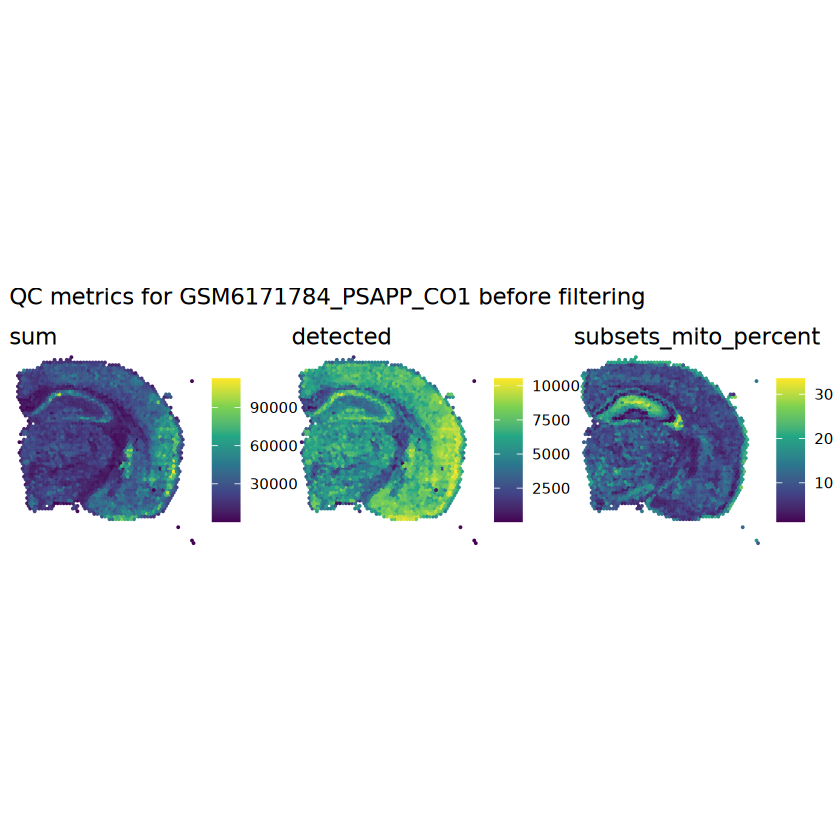

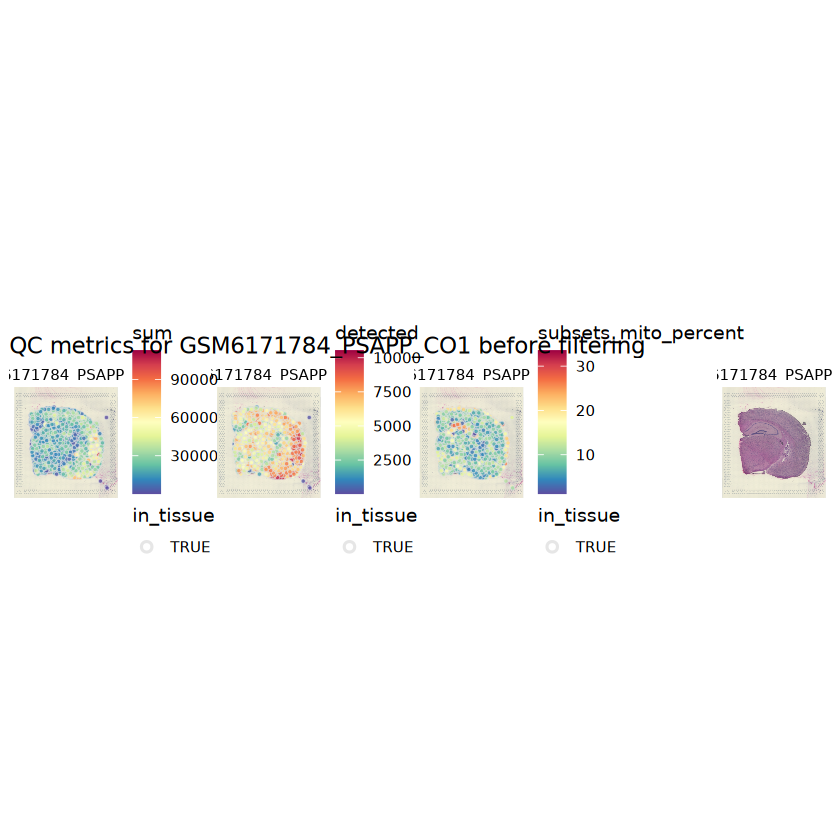

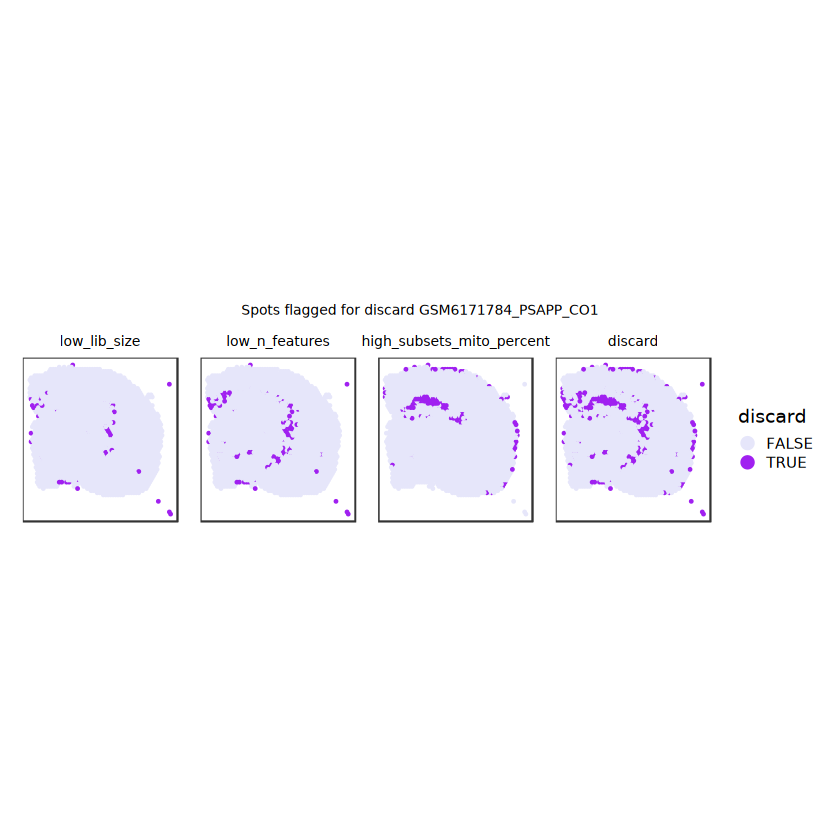

Saving 10 x 7 in image
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


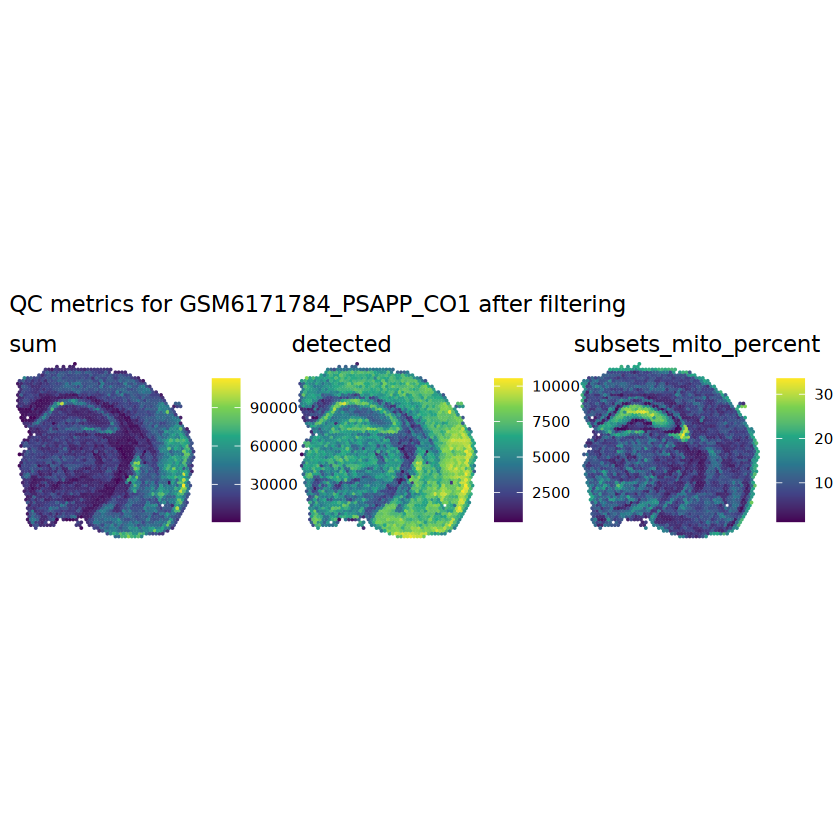

Saving 10 x 7 in image


pdf 
  2

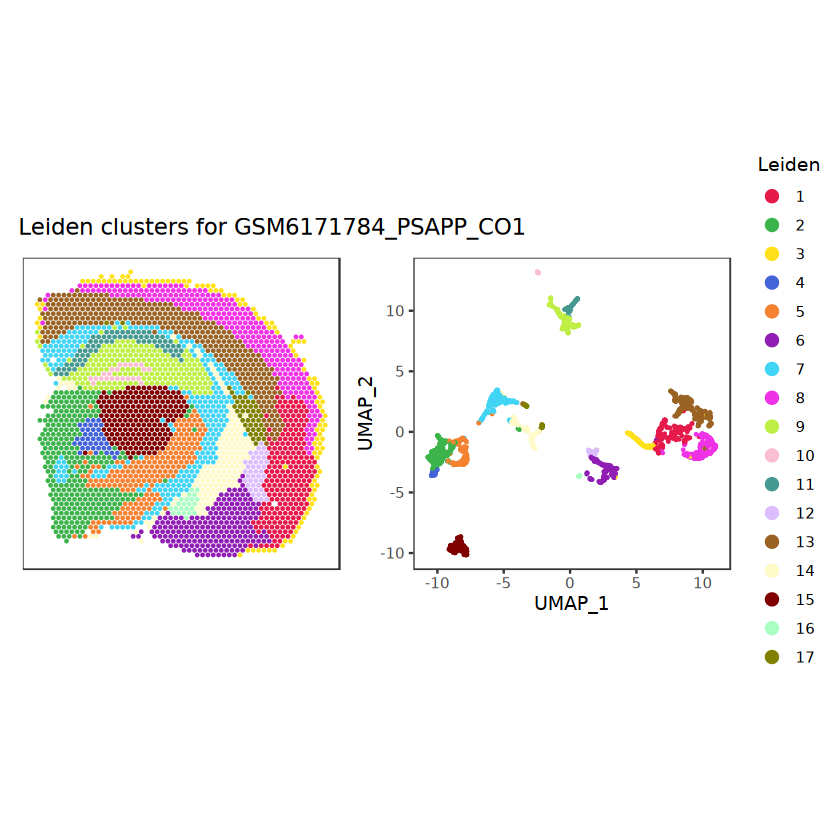

In [ ]:
# plobably plot QC of histograms separately and then use this function to plot each plot for each sample
spe_1 <- preprocess_sample(sample_dirs[1])
sample_id <- basename(sample_dirs[1])

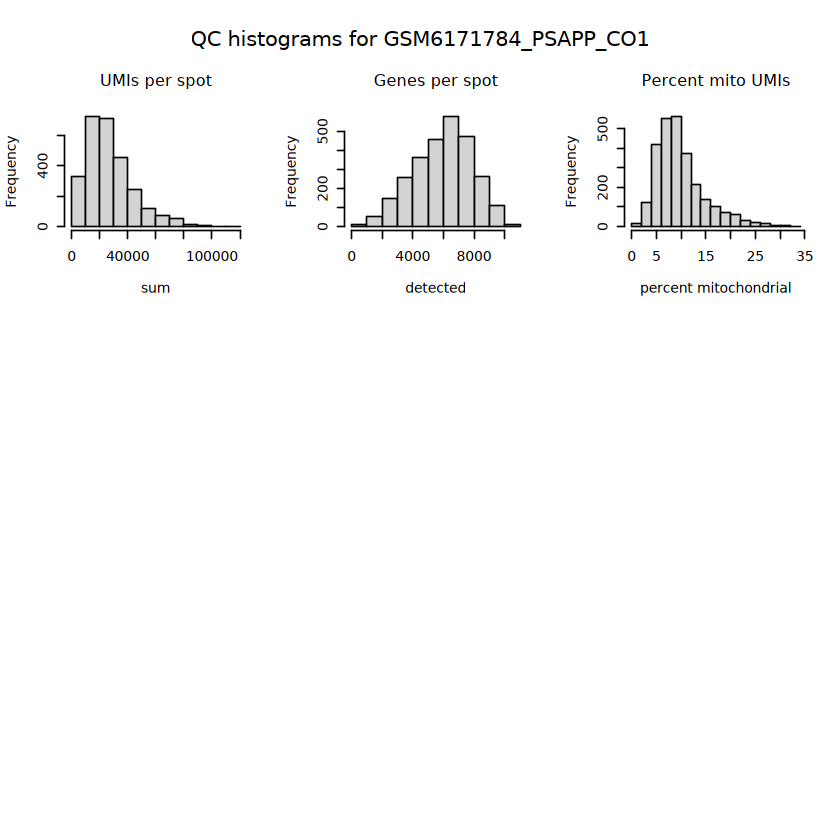

In [ ]:
# plot QC on the spatial coordinates
par(mfrow = c(3, 3), oma = c(0, 0, 3, 0))
hist(colData(spe_1)$sum, xlab = "sum", main = "UMIs per spot")
hist(colData(spe_1)$detected, xlab = "detected", main = "Genes per spot")
hist(colData(spe_1)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")
mtext(glue("QC histograms for {sample_id}"), outer = TRUE, cex = 1)


Saving 10 x 7 in image


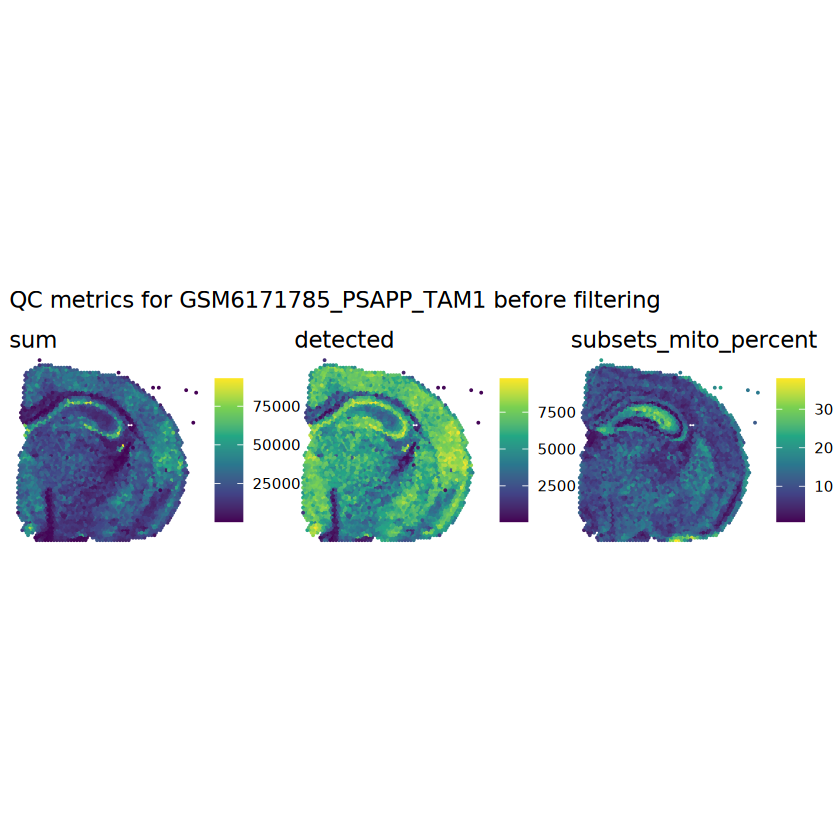

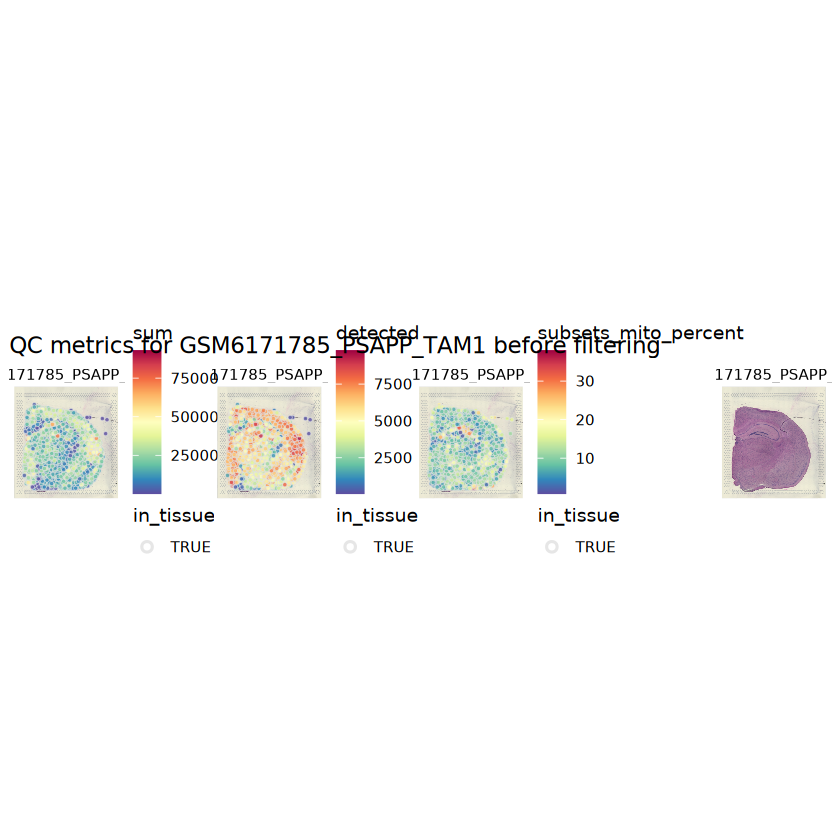

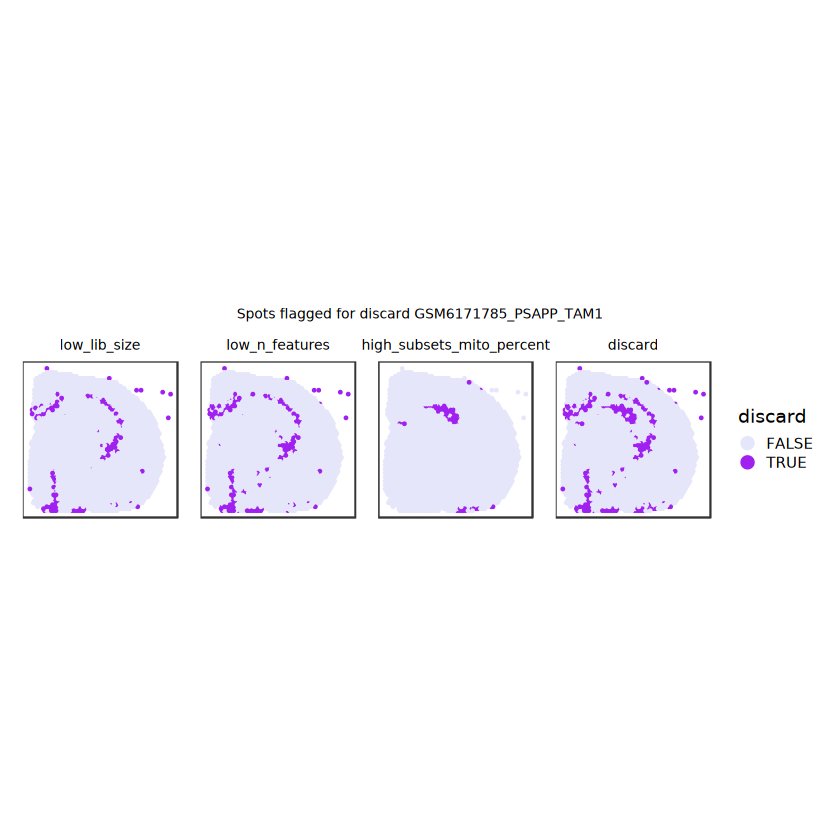

Saving 10 x 7 in image
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


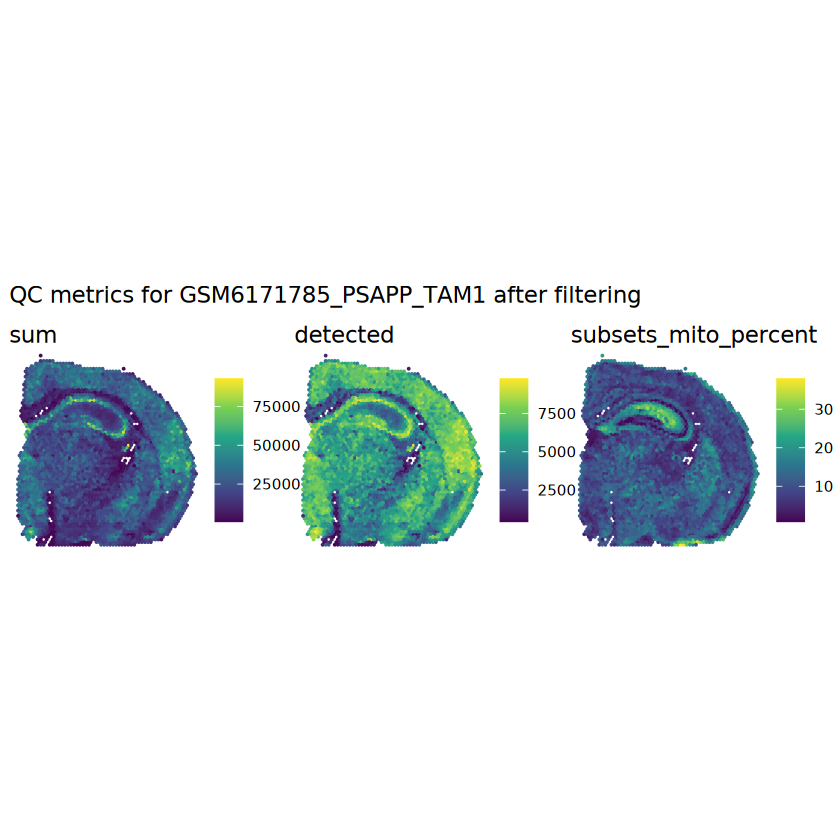

Saving 10 x 7 in image


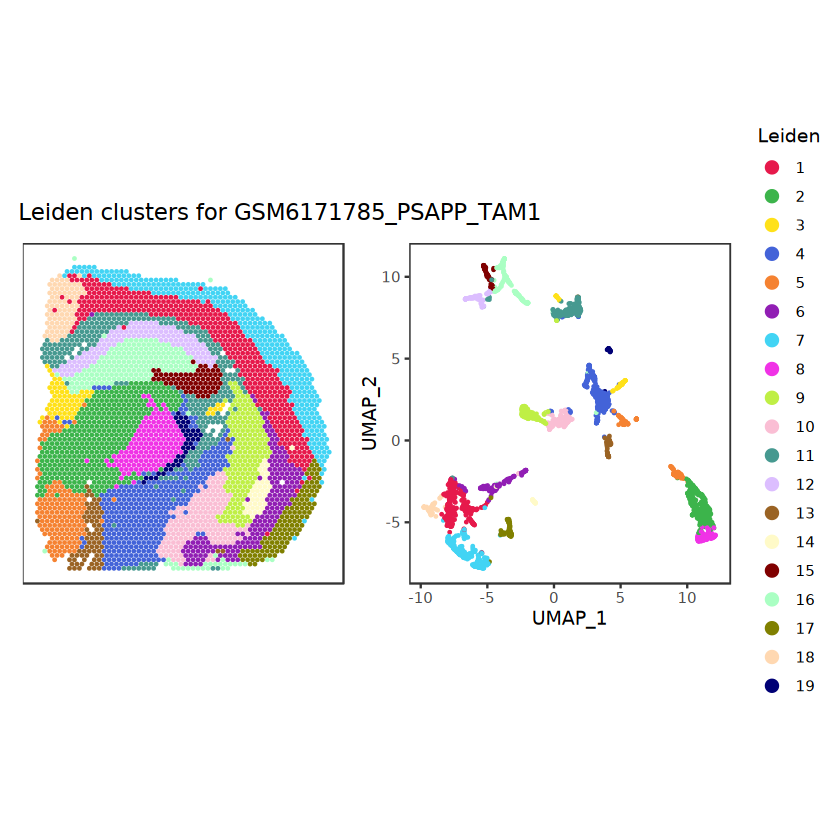

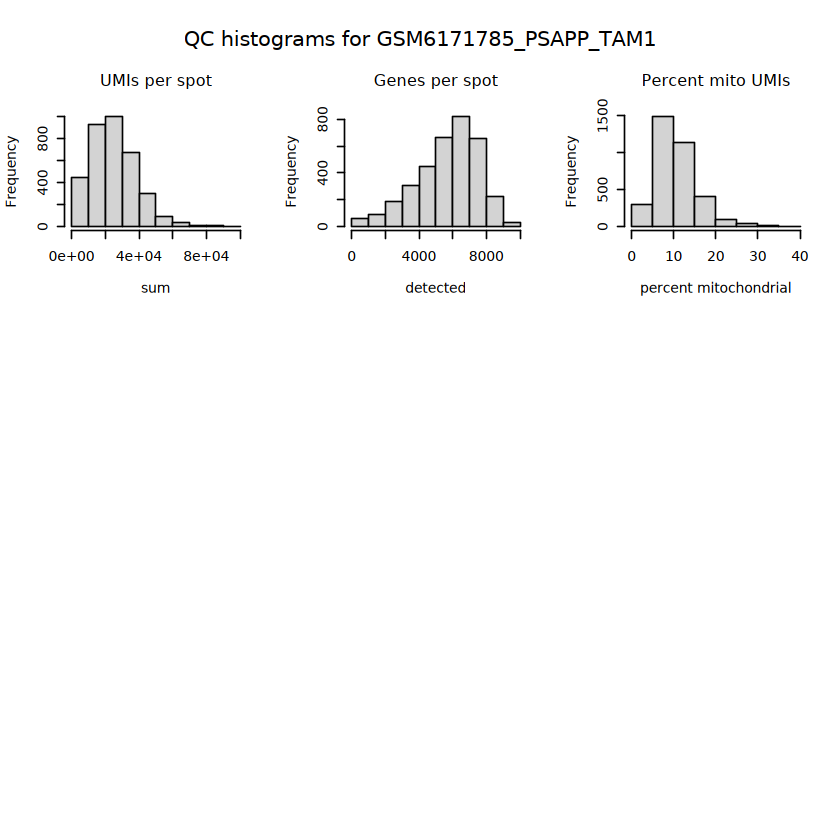

In [14]:
# process 2 sample
spe_2 <- preprocess_sample(sample_dirs[2])
sample_id <- basename(sample_dirs[2])

# histograms of QC metrics
par(mfrow = c(3, 3), oma = c(0, 0, 3, 0))  # layout
hist(colData(spe_2)$sum, xlab = "sum", main = "UMIs per spot")
hist(colData(spe_2)$detected, xlab = "detected", main = "Genes per spot")
hist(colData(spe_2)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")
mtext(glue("QC histograms for {sample_id}"), outer = TRUE, cex = 1)

Saving 10 x 7 in image


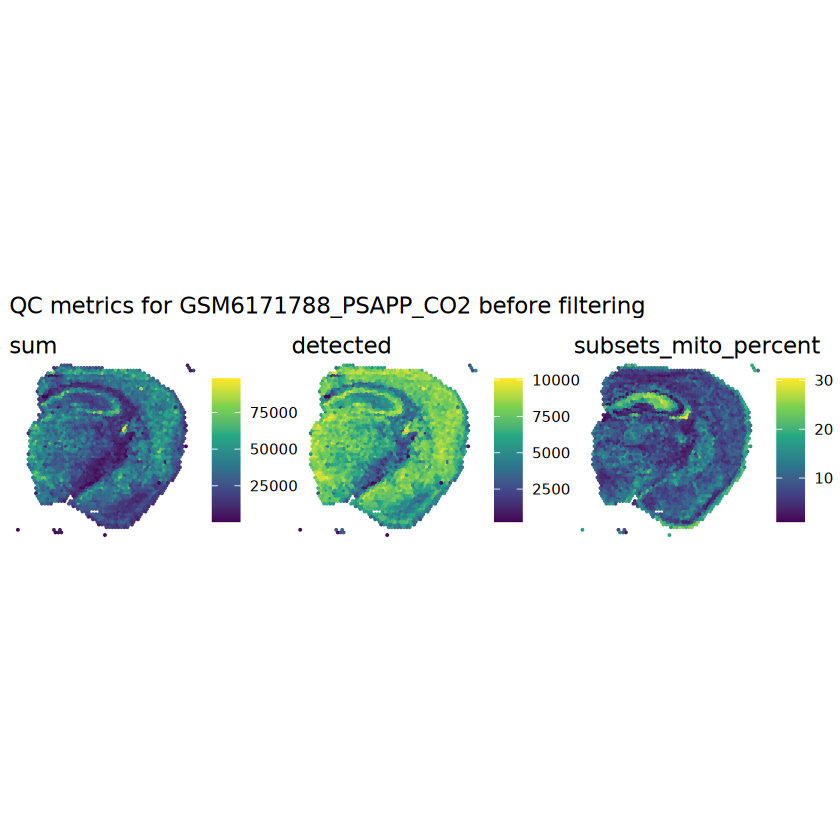

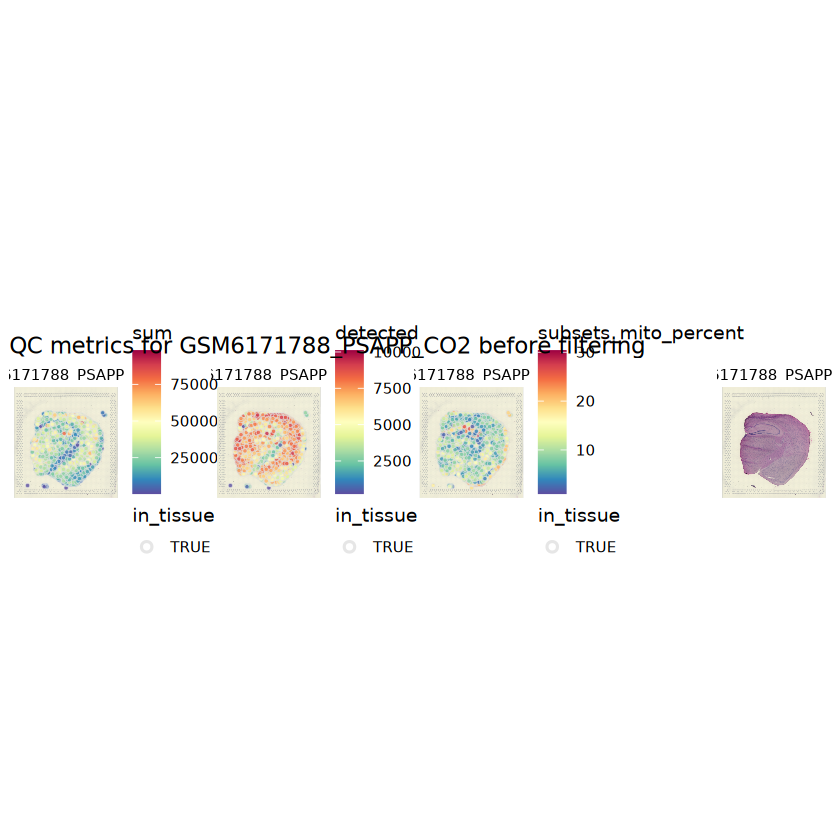

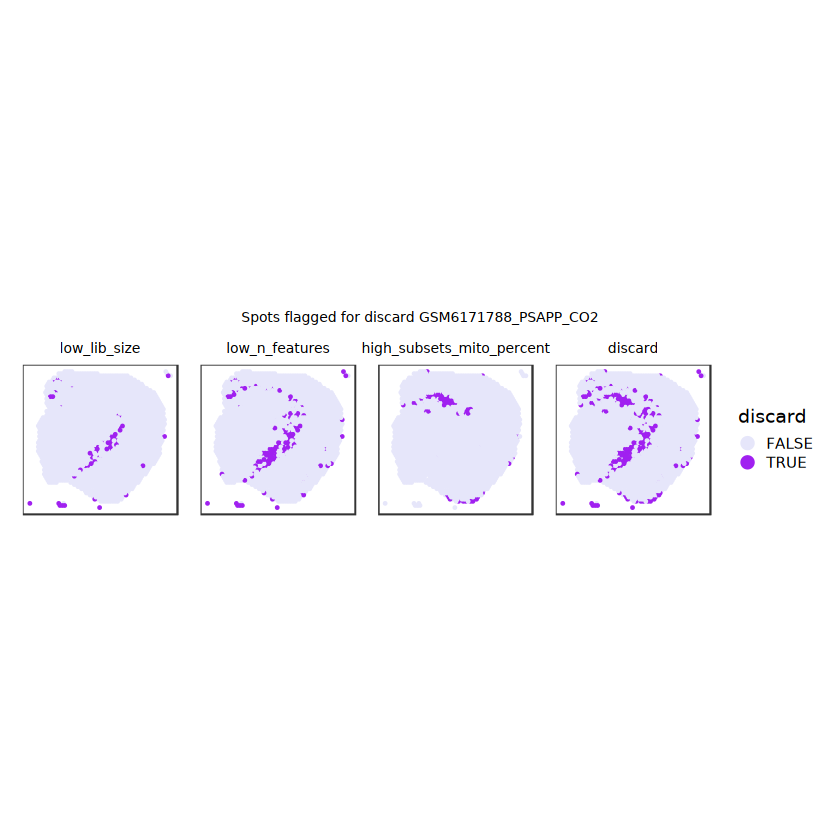

Saving 10 x 7 in image
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


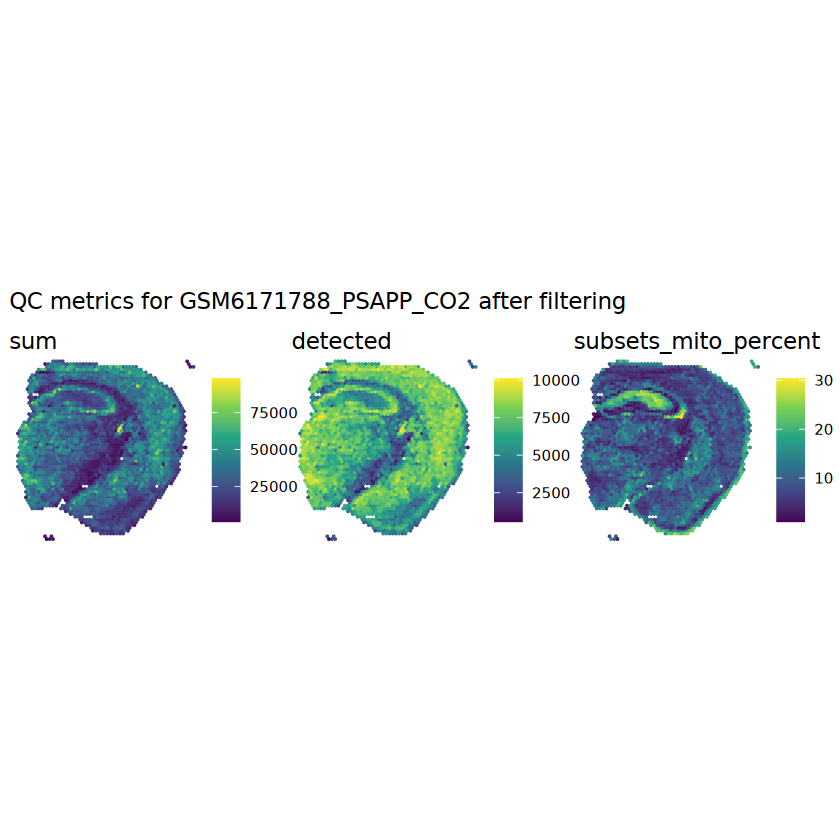

Saving 10 x 7 in image


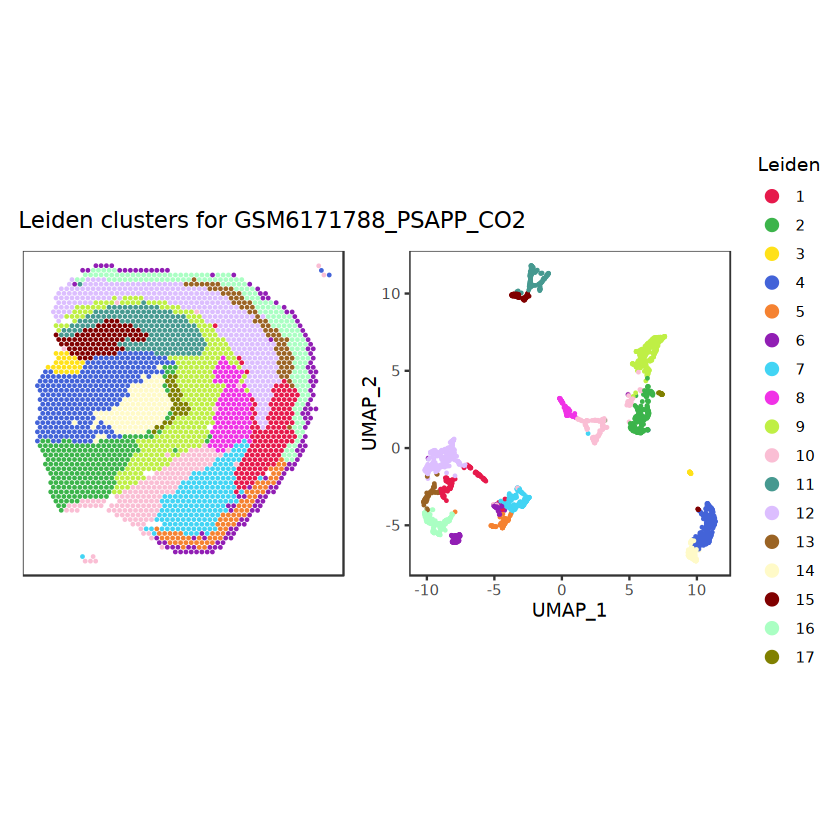

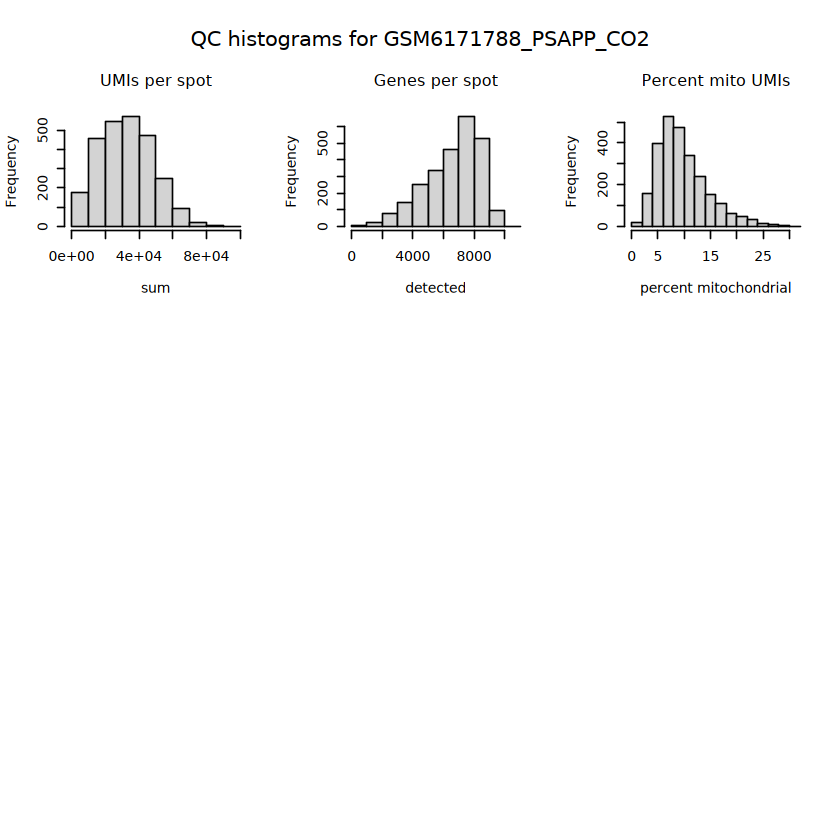

In [15]:
# process 3 sample
spe_3 <- preprocess_sample(sample_dirs[3])
sample_id <- basename(sample_dirs[3])

# histograms of QC metrics
par(mfrow = c(3, 3), oma = c(0, 0, 3, 0))  # layout
hist(colData(spe_3)$sum, xlab = "sum", main = "UMIs per spot")
hist(colData(spe_3)$detected, xlab = "detected", main = "Genes per spot")
hist(colData(spe_3)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")
mtext(glue("QC histograms for {sample_id}"), outer = TRUE, cex = 1)

Saving 10 x 7 in image


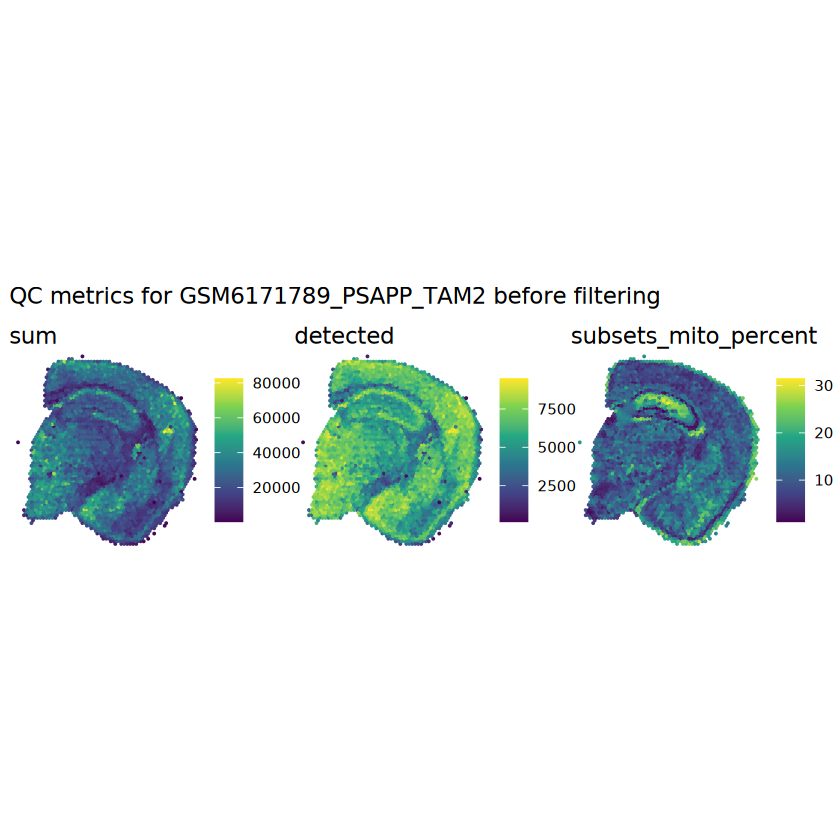

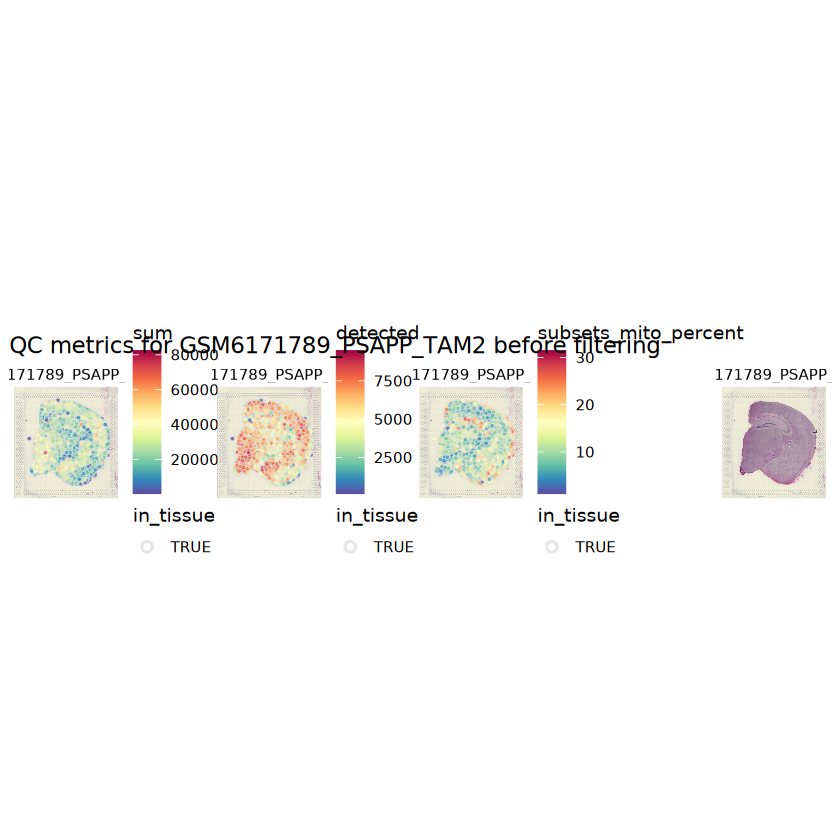

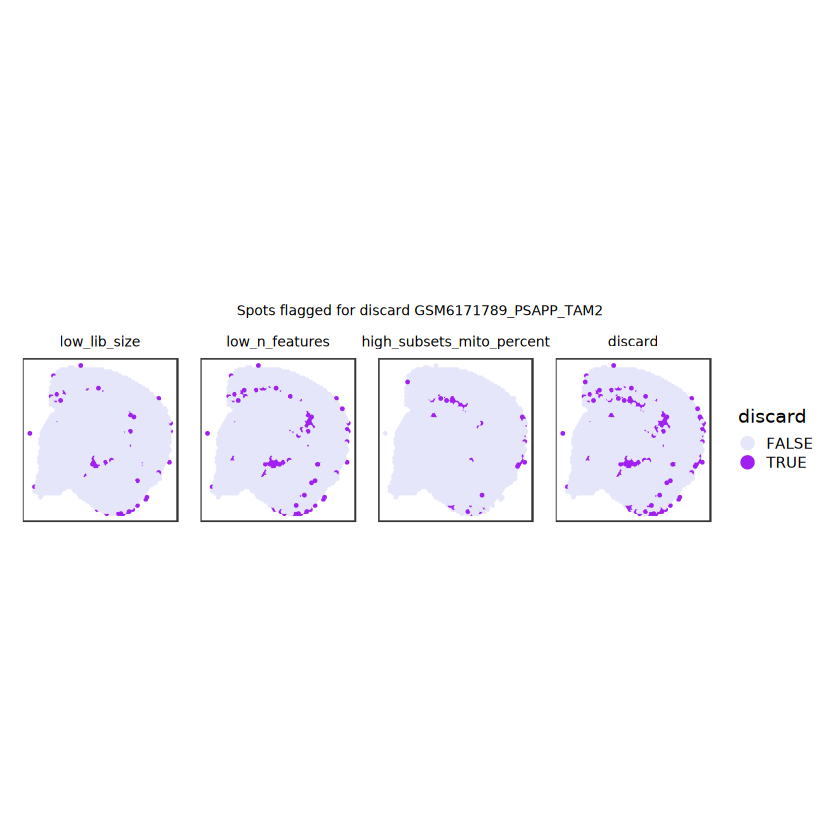

Saving 10 x 7 in image
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


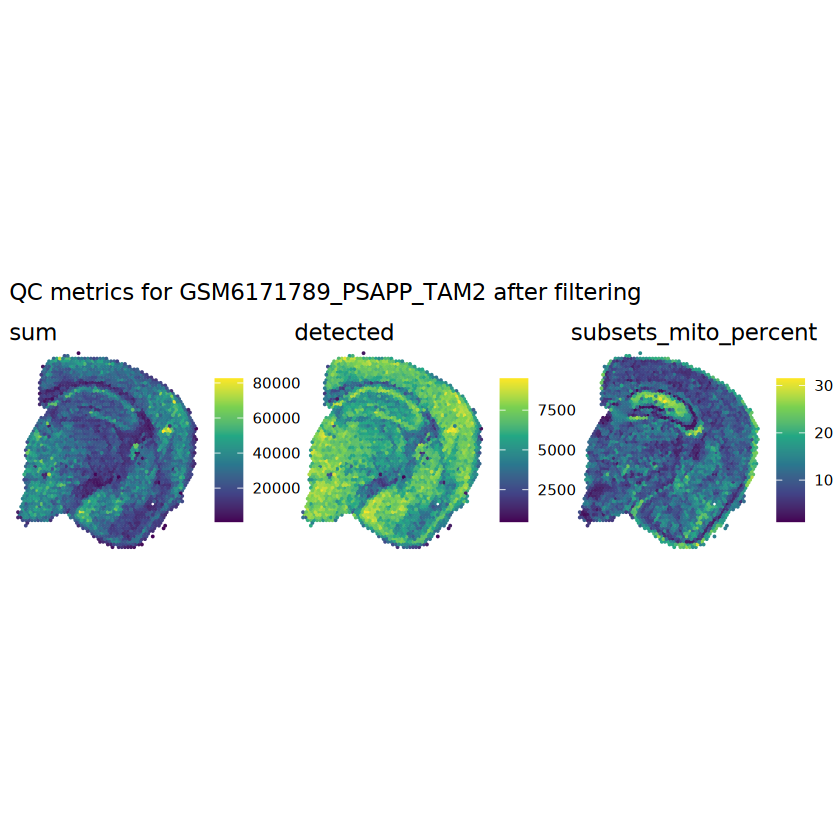

Saving 10 x 7 in image


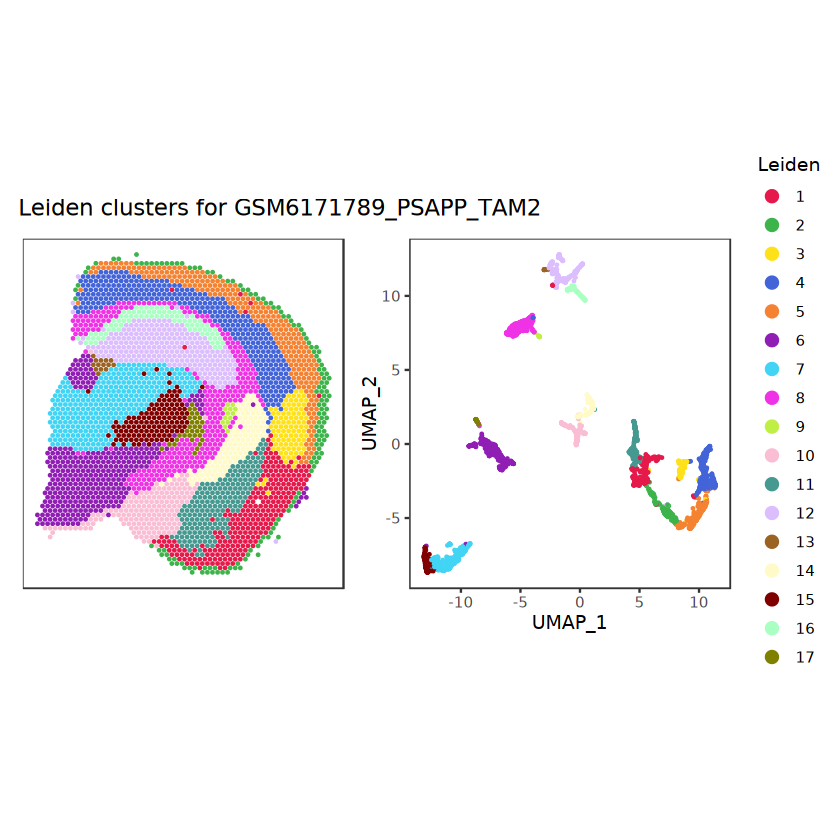

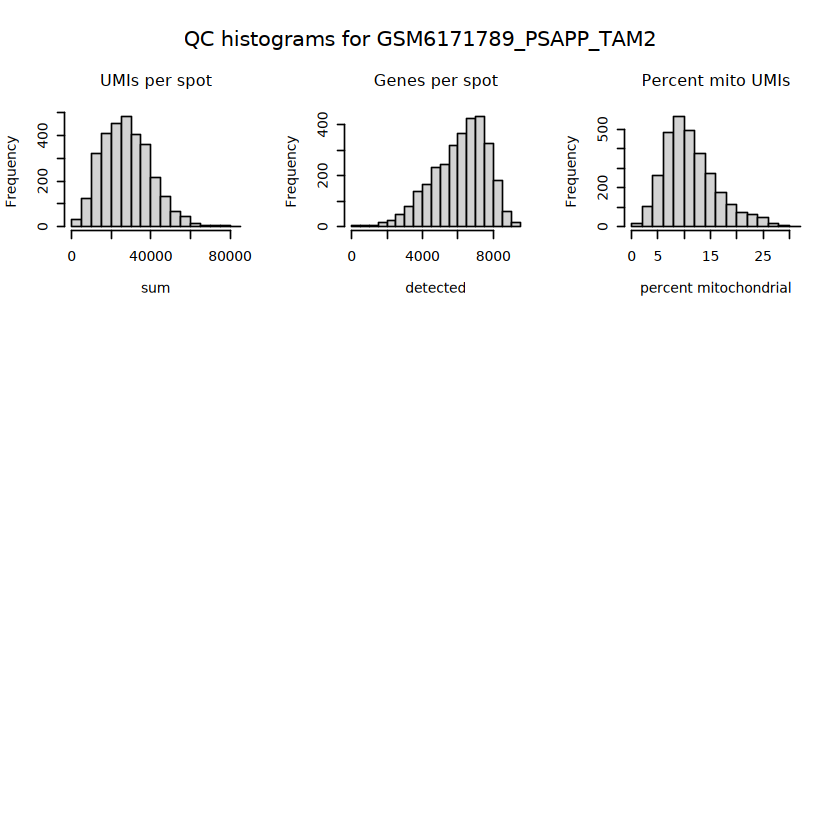

In [16]:
# process 4th sample
spe_4 <- preprocess_sample(sample_dirs[4])
sample_id <- basename(sample_dirs[4])

# histograms of QC metrics
par(mfrow = c(3, 3), oma = c(0, 0, 3, 0))  # layout
hist(colData(spe_4)$sum, xlab = "sum", main = "UMIs per spot")
hist(colData(spe_4)$detected, xlab = "detected", main = "Genes per spot")
hist(colData(spe_4)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")
mtext(glue("QC histograms for {sample_id}"), outer = TRUE, cex = 1)

Saving 10 x 7 in image


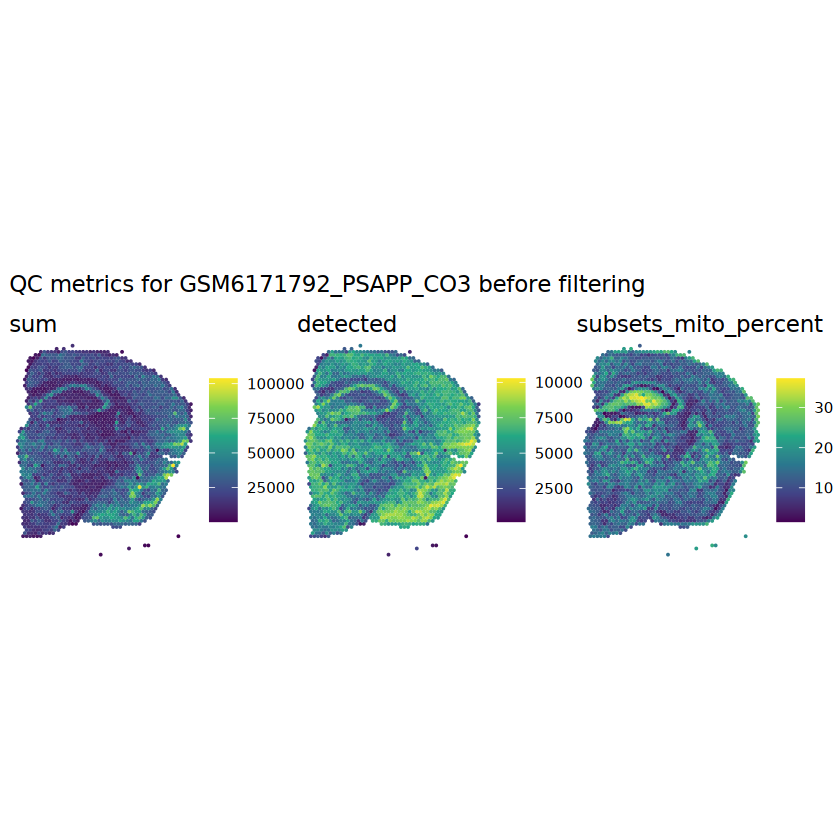

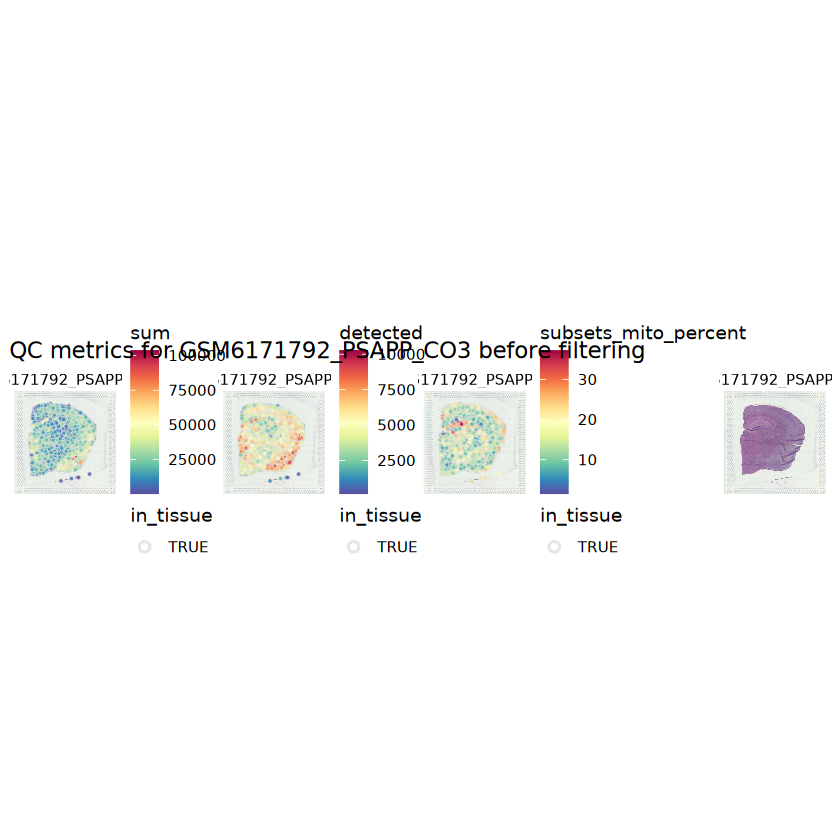

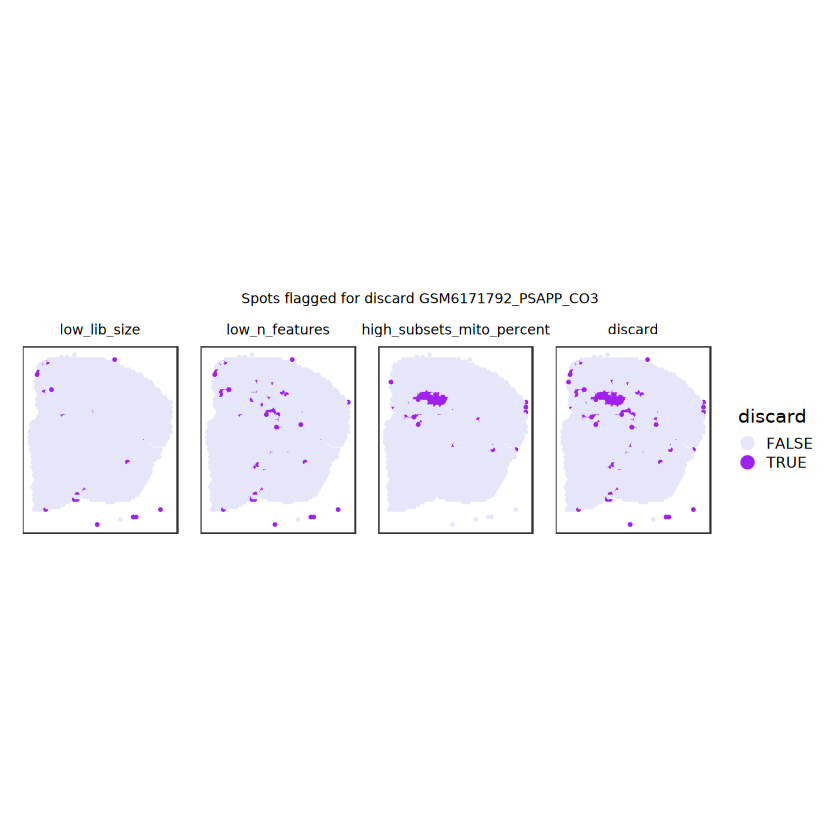

Saving 10 x 7 in image
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


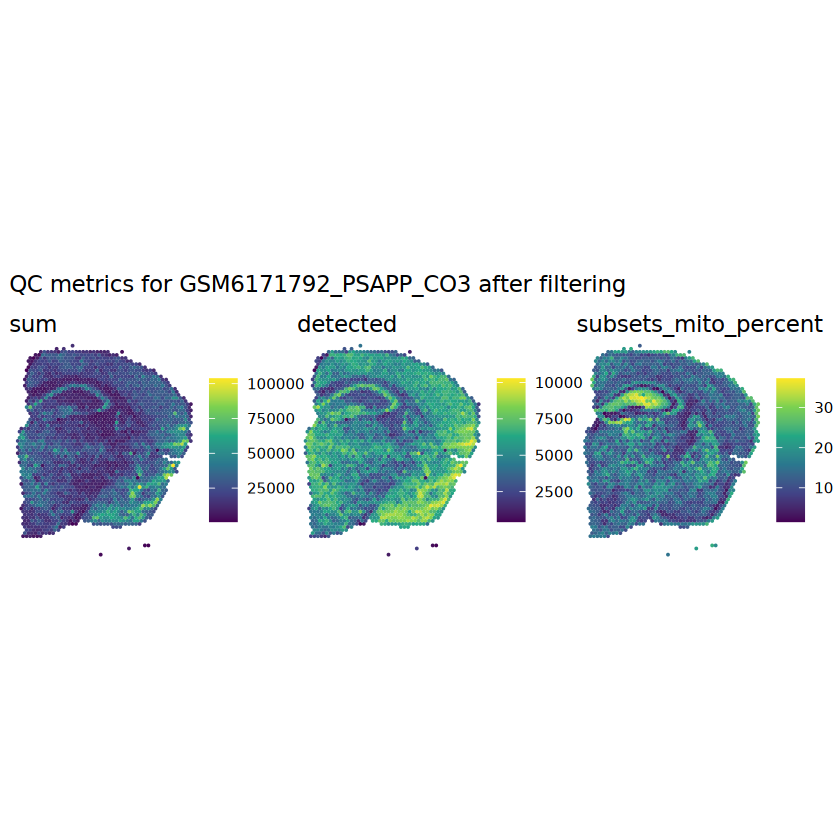

Saving 10 x 7 in image


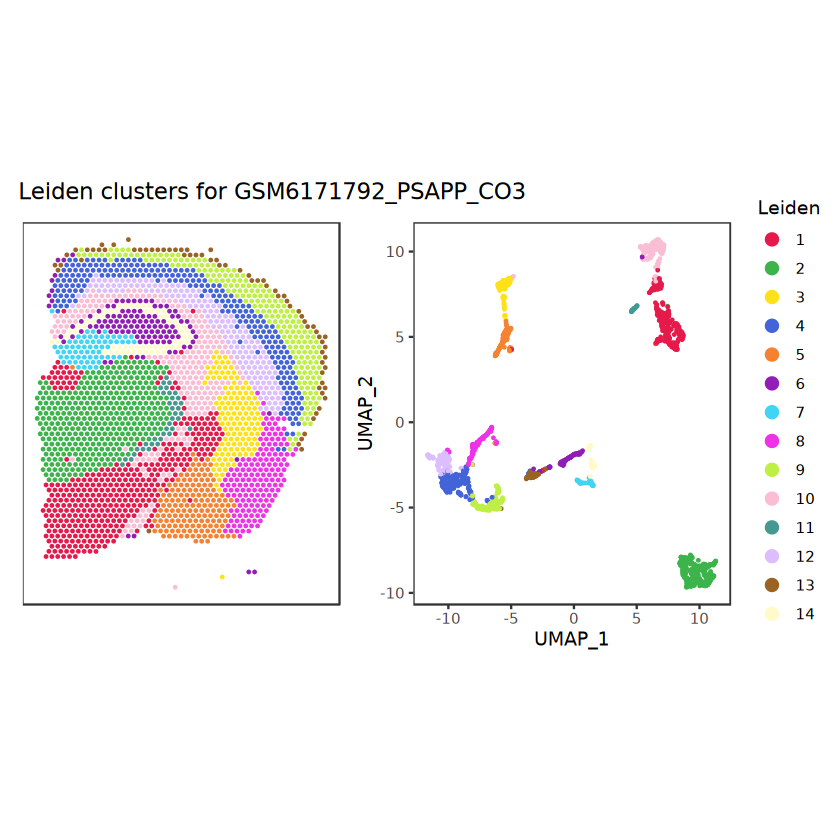

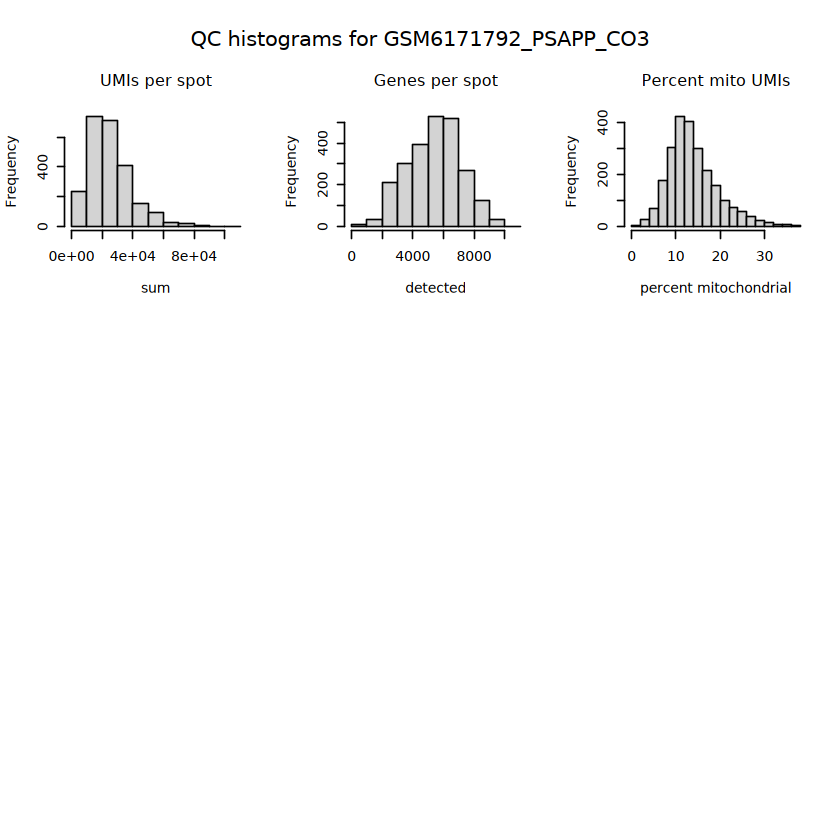

In [17]:
# process 5th sample
spe_5 <- preprocess_sample(sample_dirs[5])
sample_id <- basename(sample_dirs[5])

# histograms of QC metrics 
par(mfrow = c(3, 3), oma = c(0, 0, 3, 0))  # layout
hist(colData(spe_5)$sum, xlab = "sum", main = "UMIs per spot")
hist(colData(spe_5)$detected, xlab = "detected", main = "Genes per spot")
hist(colData(spe_5)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")
mtext(glue("QC histograms for {sample_id}"), outer = TRUE, cex = 1)

Saving 10 x 7 in image


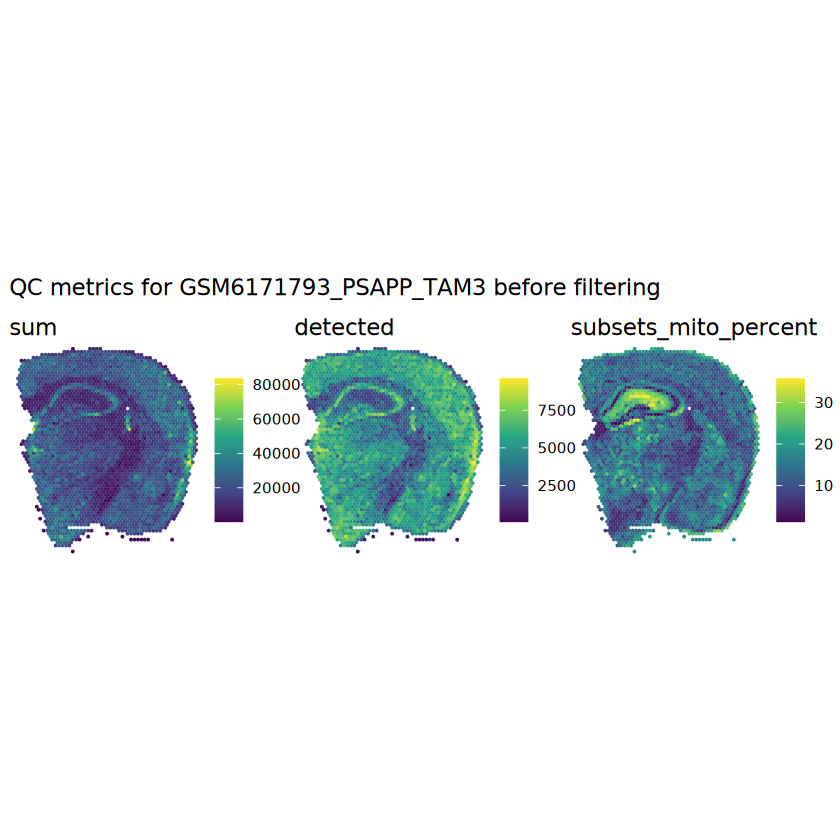

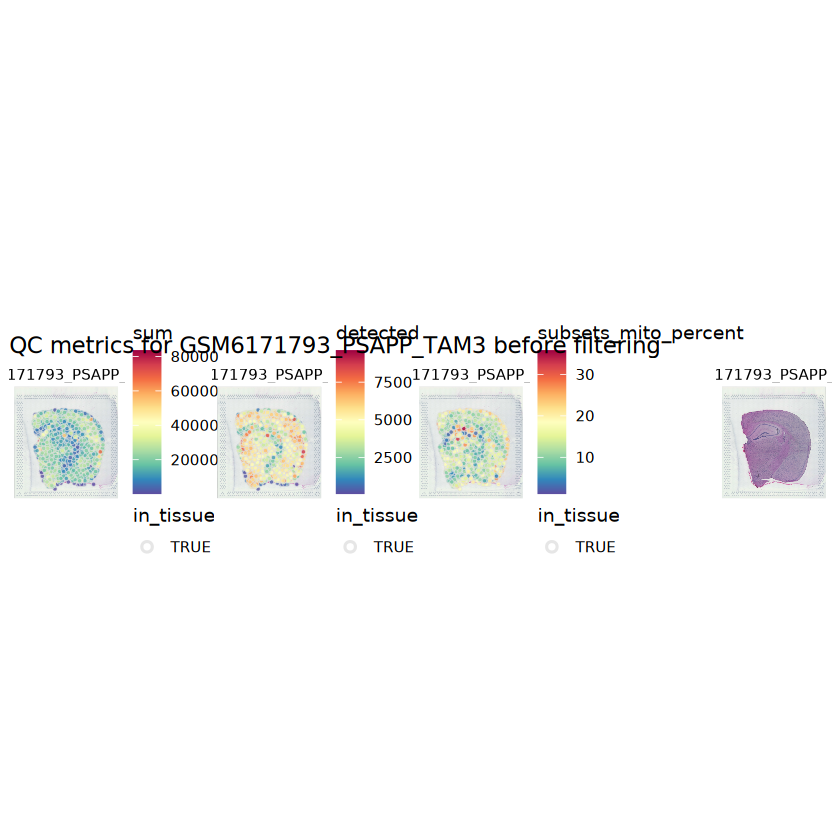

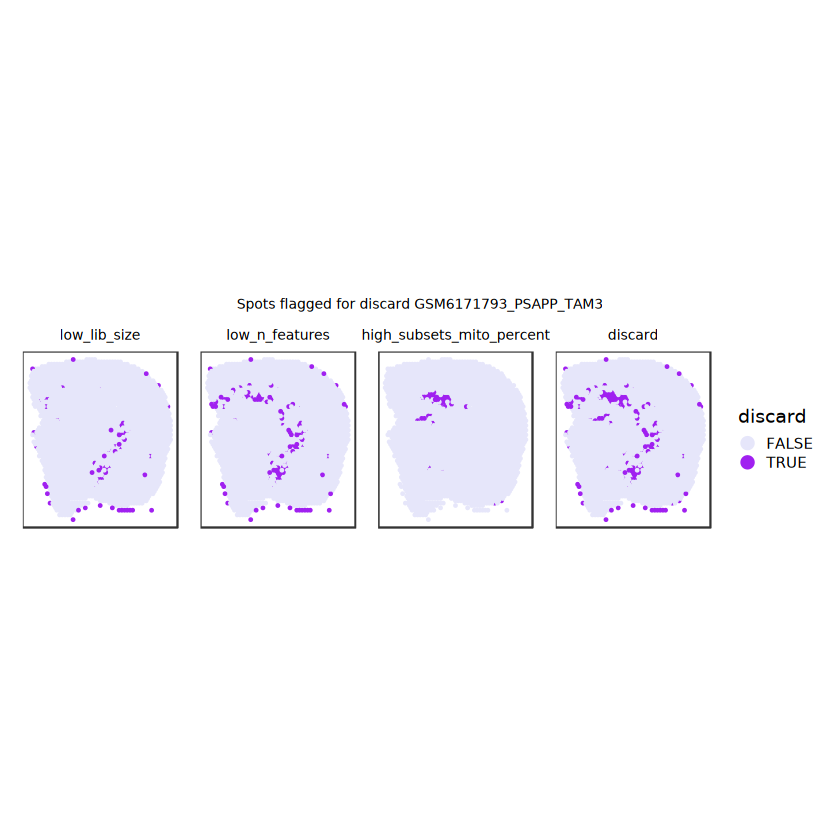

Saving 10 x 7 in image
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


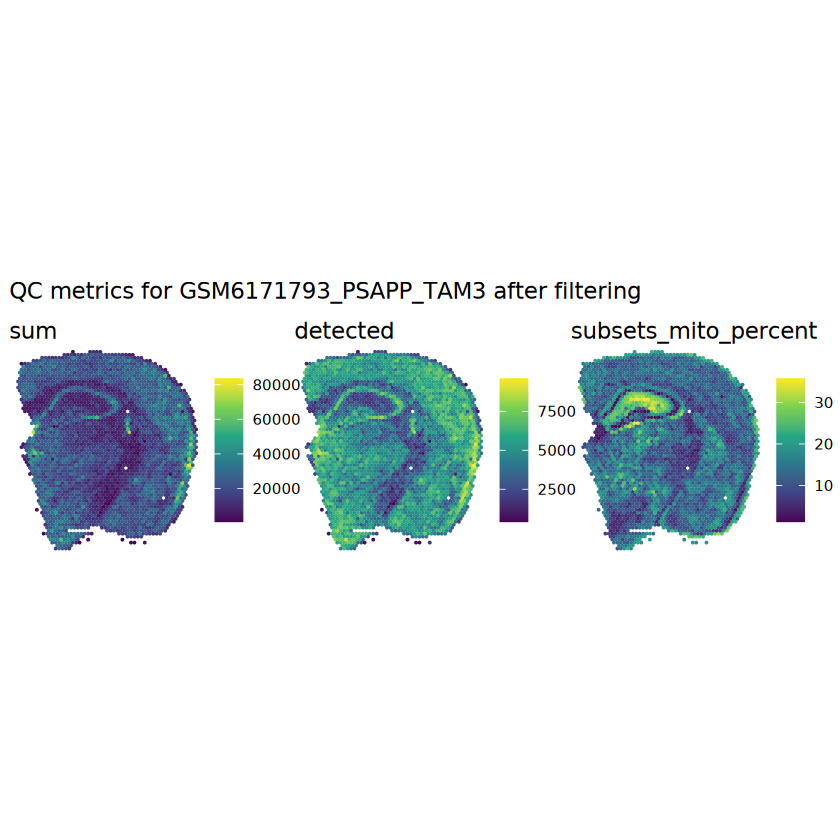

Saving 10 x 7 in image


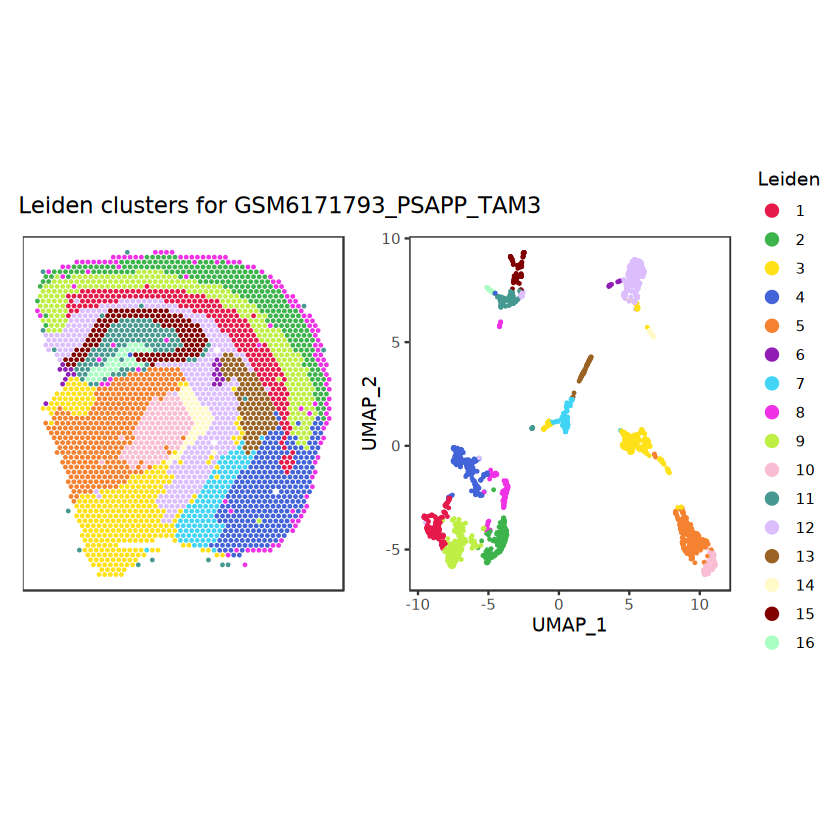

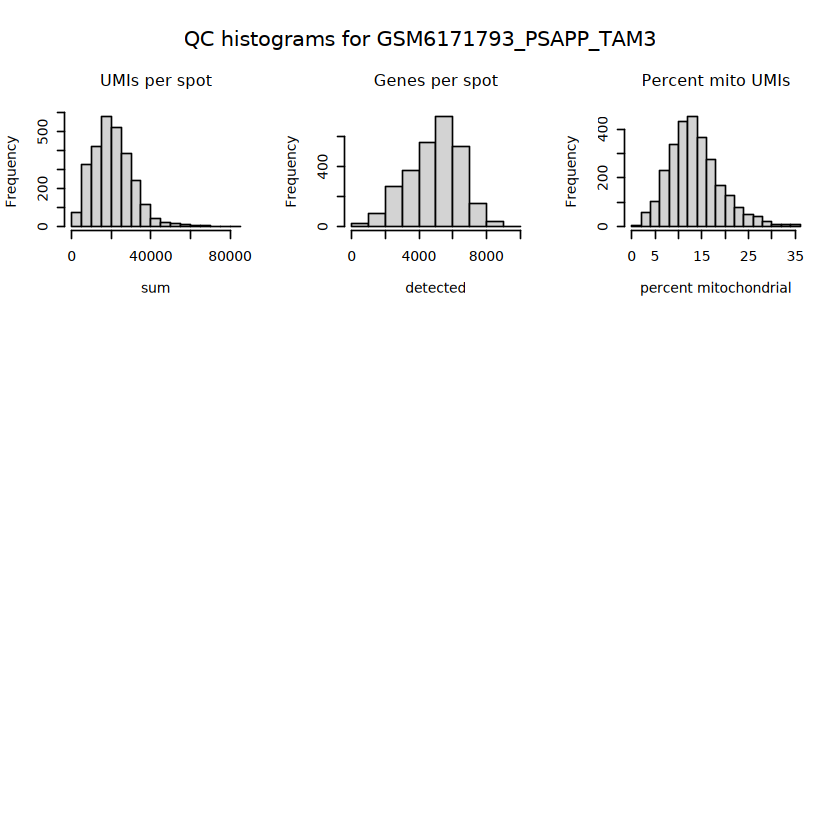

In [19]:
# process 6th sample
spe_6 <- preprocess_sample(sample_dirs[6])
sample_id <- basename(sample_dirs[6])

# histograms of QC metrics
par(mfrow = c(3, 3), oma = c(0, 0, 3, 0))  # layout
hist(colData(spe_6)$sum, xlab = "sum", main = "UMIs per spot")
hist(colData(spe_6)$detected, xlab = "detected", main = "Genes per spot")
hist(colData(spe_6)$subsets_mito_percent, xlab = "percent mitochondrial", main = "Percent mito UMIs")
mtext(glue("QC histograms for {sample_id}"), outer = TRUE, cex = 1)